# **Import Libraries**

In [49]:
pip install pandas numpy matplotlib seaborn scikit-learn openpyxl

In [50]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# **Load the Dataset**

In [51]:
# Load the Excel dataset
file_path = 'Online Retail.xlsx'
df = pd.read_excel(file_path)

# Preview the data
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# **Dataset Overview**

In [52]:
# Check dataset structure
print("Shape of dataset:", df.shape)
print("\nColumns:\n", df.columns)

# Summary of data
df.info()

Shape of dataset: (541909, 8)

Columns:
 Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


# **Data Preprocessing**

Handle Missing Data

In [53]:
# Check missing values
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


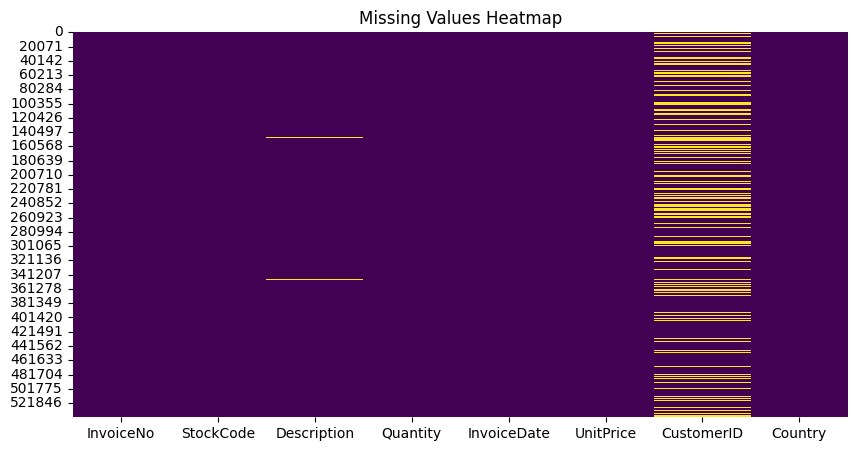

In [54]:
plt.figure(figsize=(10, 5))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

In [55]:
# Remove rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Ensure all CustomerIDs are integers
df['CustomerID'] = df['CustomerID'].astype(int)

<ipython-input-55-23e1c83527a3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CustomerID'] = df['CustomerID'].astype(int)


Remove Canceled Transactions

In [56]:
# Filter out canceled transactions
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [57]:
print("Data shape after cleaning:", df.shape)
df.describe(include='all')

Data shape after cleaning: (397924, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
count,397924.0,397924,397924,397924.000000,397924,397924.000000,397924.000000,397924
unique,18536.0,3665,3877,NaN,NaN,NaN,NaN,37
top,576339.0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,NaN,NaN,NaN,United Kingdom
freq,542.0,2035,2028,NaN,NaN,NaN,NaN,354345
mean,NaN,NaN,NaN,13.021823,2011-07-10 23:43:36.912475648,3.116174,15294.315171,NaN
min,NaN,NaN,NaN,1.000000,2010-12-01 08:26:00,0.000000,12346.000000,NaN
25%,NaN,NaN,NaN,2.000000,2011-04-07 11:12:00,1.250000,13969.000000,NaN
50%,NaN,NaN,NaN,6.000000,2011-07-31 14:39:00,1.950000,15159.000000,NaN
75%,NaN,NaN,NaN,12.000000,2011-10-20 14:33:00,3.750000,16795.000000,NaN
max,NaN,NaN,NaN,80995.000000,2011-12-09 12:50:00,8142.750000,18287.000000,NaN


# **Feature Engineering – RFM Analysis**

Create a Reference Date

In [58]:
# Reference date for Recency calculation (typically the day after the last transaction)
import datetime as dt
ref_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

RFM Table

In [59]:
# Add TotalPrice column to original df first
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                              # Frequency
    'TotalPrice': lambda x: x.sum() if 'TotalPrice' in x else 0  # We'll calculate TotalPrice below
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency'
})

In [60]:
# Now recalculate Monetary (which relies on TotalPrice)
monetary = df.groupby('CustomerID')['TotalPrice'].sum()

# Merge into RFM
rfm['Monetary'] = monetary

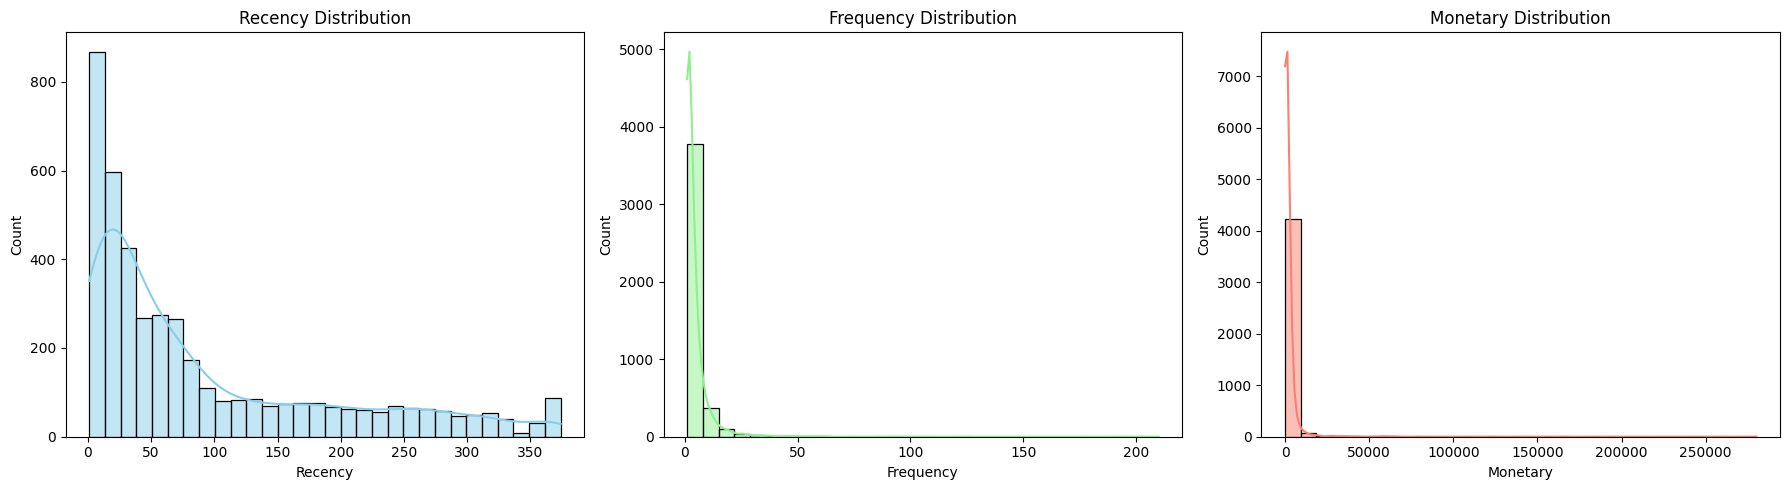

In [61]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm['Recency'], bins=30, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=30, kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins=30, kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()

Feature Scaling

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# Convert back to DataFrame for readability
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm.columns, index=rfm.index)


# **Dimensionality Reduction with PCA (Principal Component Analysis)**

In [63]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Apply PCA

In [64]:
pca = PCA(n_components=2)  # Reduce to 2D for visualization
rfm_pca = pca.fit_transform(rfm_scaled)

# Convert to DataFrame
pca_df = pd.DataFrame(data=rfm_pca, columns=['PCA1', 'PCA2'])


In [65]:
print("Explained Variance Ratio (PCA):", pca.explained_variance_ratio_)
print("Total Variance Captured:", sum(pca.explained_variance_ratio_))

Explained Variance Ratio (PCA): [0.55508353 0.30254725]
Total Variance Captured: 0.857630778288257


Visualize the PCA Result

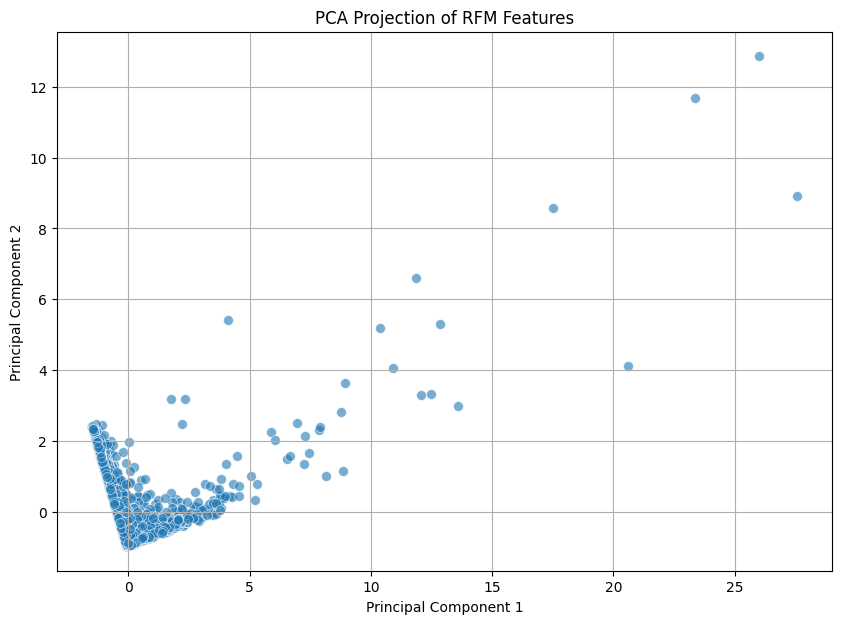

In [66]:
plt.figure(figsize=(10, 7))
sns.scatterplot(x='PCA1', y='PCA2', data=pca_df, s=50, alpha=0.6)
plt.title('PCA Projection of RFM Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Use 3D PCA for Better Cluster Separation

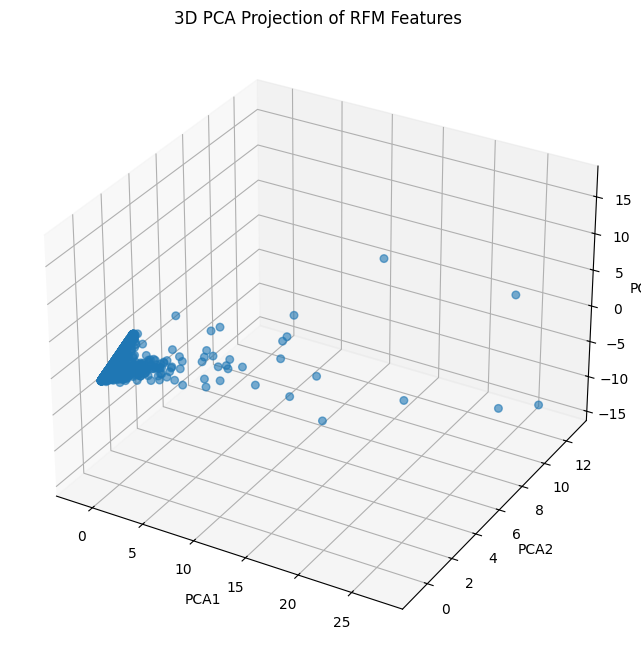

In [67]:
from mpl_toolkits.mplot3d import Axes3D

pca_3d = PCA(n_components=3)
rfm_pca_3d = pca_3d.fit_transform(rfm_scaled)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(rfm_pca_3d[:, 0], rfm_pca_3d[:, 1], rfm_pca_3d[:, 2], s=30, alpha=0.6)
ax.set_title("3D PCA Projection of RFM Features")
ax.set_xlabel("PCA1")
ax.set_ylabel("PCA2")
ax.set_zlabel("PCA3")
plt.show()

# **K-Means Clustering**

Optimal Number of Clusters (K)

In [68]:
wcss = []
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

Text(0.5, 1.0, 'Elbow Method for Optimal K')

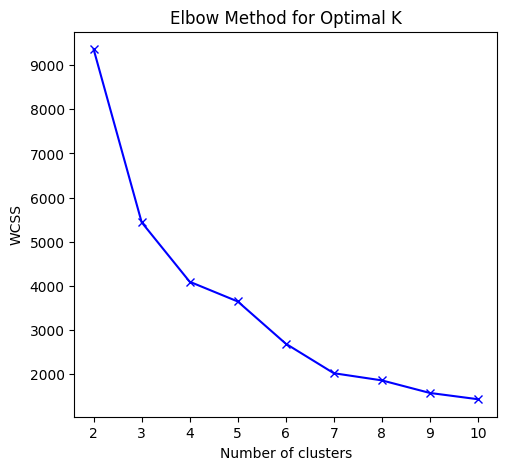

In [69]:
# Plot WCSS (Elbow Method)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, wcss, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')

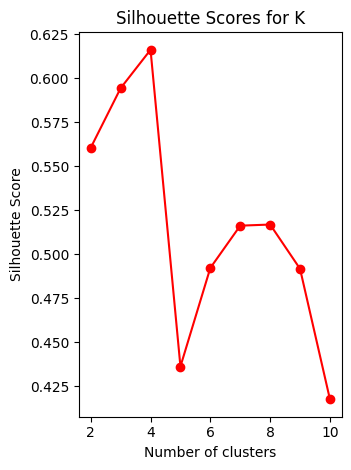

In [70]:
# Plot Silhouette Scores
plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'ro-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for K')

plt.tight_layout()
plt.show()

Apply K-Means Clustering

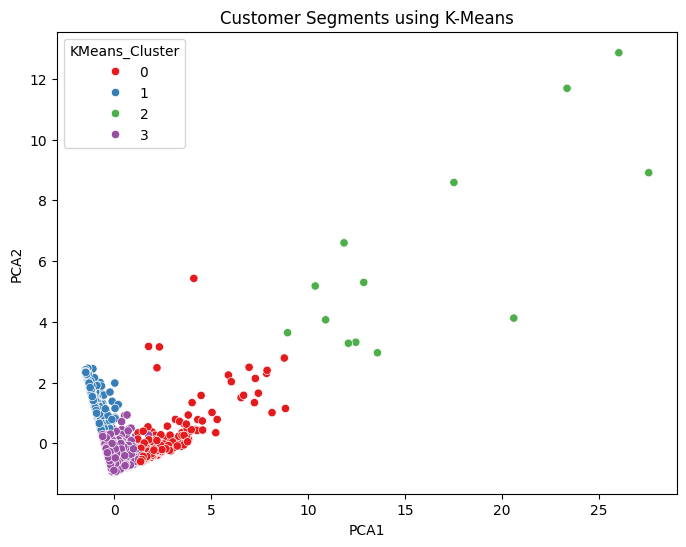

In [71]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(rfm_scaled)

# Append cluster labels to the PCA-reduced DataFrame
pca_df['KMeans_Cluster'] = kmeans_labels

# Visualize the clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='KMeans_Cluster', palette='Set1')
plt.title('Customer Segments using K-Means')
plt.show()

# **DBSCAN**

Apply DBSCAN

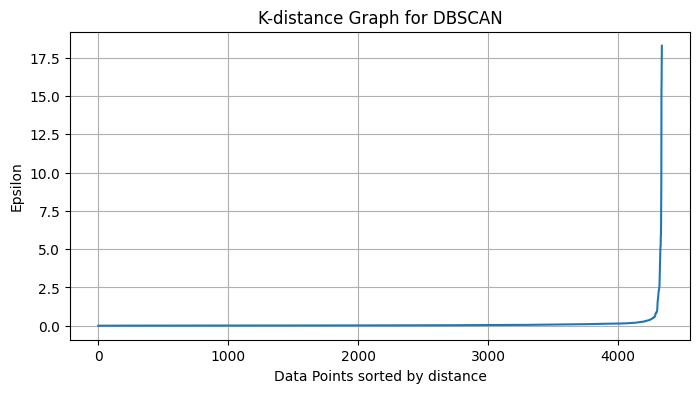

In [72]:
from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(rfm_scaled)
distances, indices = neighbors_fit.kneighbors(rfm_scaled)

# Plot the distances to estimate eps
distances = np.sort(distances[:, 4])
plt.figure(figsize=(8, 4))
plt.plot(distances)
plt.title('K-distance Graph for DBSCAN')
plt.xlabel('Data Points sorted by distance')
plt.ylabel('Epsilon')
plt.grid(True)
plt.show()

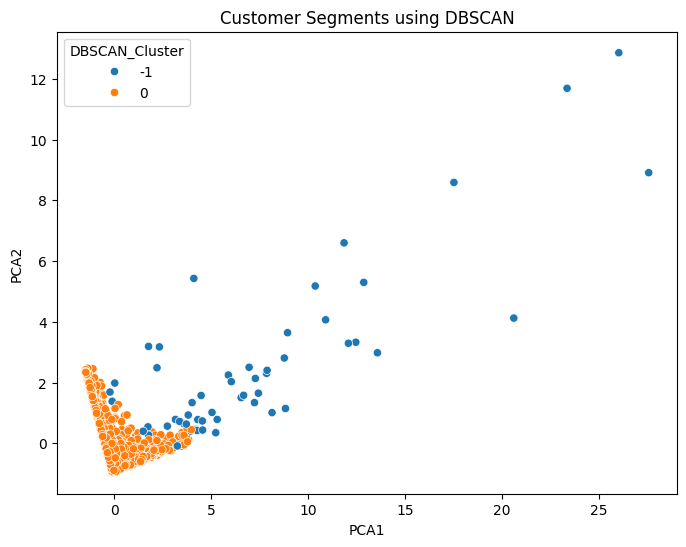

In [73]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(rfm_scaled)

# Visualize DBSCAN Clusters
pca_df['DBSCAN_Cluster'] = dbscan_labels
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='DBSCAN_Cluster', palette='tab10')
plt.title('Customer Segments using DBSCAN')
plt.show()

# **Gaussian Mixture Models (GMM)**

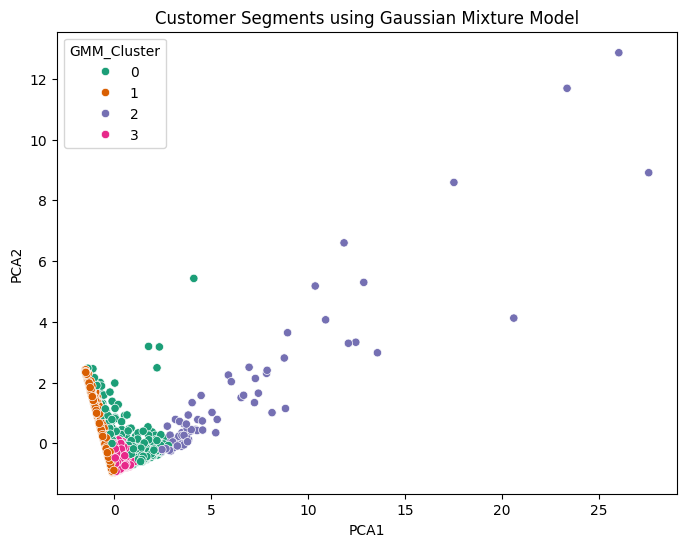

In [74]:
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(rfm_scaled)

# Visualize GMM Clusters
pca_df['GMM_Cluster'] = gmm_labels
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='GMM_Cluster', palette='Dark2')
plt.title('Customer Segments using Gaussian Mixture Model')
plt.show()


# **Deep Embedded Clustering (DEC)**

In [75]:
pip install tensorflow scikit-learn matplotlib seaborn

Build the Autoencoder

In [76]:
input_dim = rfm_scaled.shape[1]
encoding_dim = 2

input_layer = Input(shape=(input_dim,))
encoded = Dense(5, activation='relu', activity_regularizer=regularizers.l1(1e-5))(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)

decoded = Dense(5, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)

autoencoder.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

In [77]:
autoencoder.fit(rfm_scaled, rfm_scaled, epochs=50, batch_size=32, shuffle=True, verbose=1)

Epoch 1/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.7199
Epoch 2/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5272
Epoch 3/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4544
Epoch 4/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4800
Epoch 5/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6175
Epoch 6/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4120
Epoch 7/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5456
Epoch 8/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5280
Epoch 9/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4586
Epoch 10/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3546
Epoch 11/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7469
Epoch 12/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5777
Epoch 13/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5926
Epoch 14/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4048
Epoch 15/50
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

Encode the RFM Data

In [78]:
encoded_data = encoder.predict(rfm_scaled)

136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [79]:
kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(encoded_data)

Apply K-Means to the encoded data

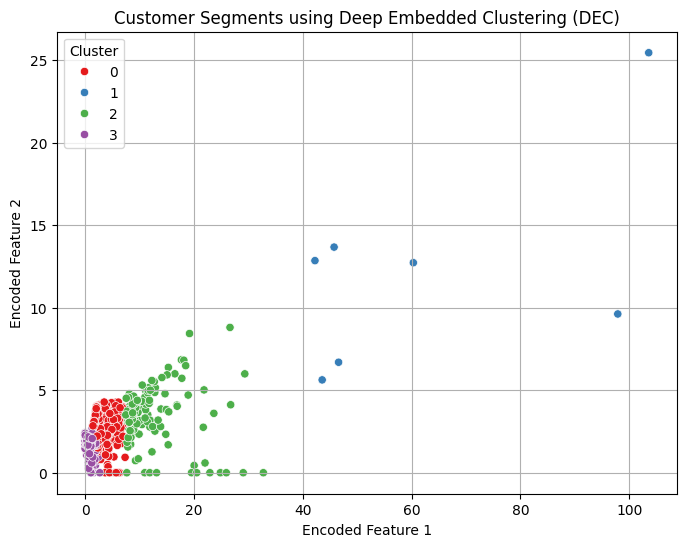

In [80]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=encoded_data[:, 0], y=encoded_data[:, 1], hue=cluster_labels, palette='Set1')
plt.title('Customer Segments using Deep Embedded Clustering (DEC)')
plt.xlabel('Encoded Feature 1')
plt.ylabel('Encoded Feature 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


# **Evaluation Techniques**

Internal Validation Metrics

In [81]:
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.2f}')

Silhouette Score: 0.33


Davies-Bouldin Index

In [82]:
from sklearn.metrics import davies_bouldin_score

db_score = davies_bouldin_score(rfm_scaled, cluster_labels)
print(f'Davies-Bouldin Index: {db_score:.2f}')

Davies-Bouldin Index: 0.89


Calinski-Harabasz Index

In [83]:
from sklearn.metrics import calinski_harabasz_score

ch_score = calinski_harabasz_score(rfm_scaled, cluster_labels)
print(f'Calinski-Harabasz Index: {ch_score:.2f}')

Calinski-Harabasz Index: 1266.98


Using PCA for Dimensionality Reduction

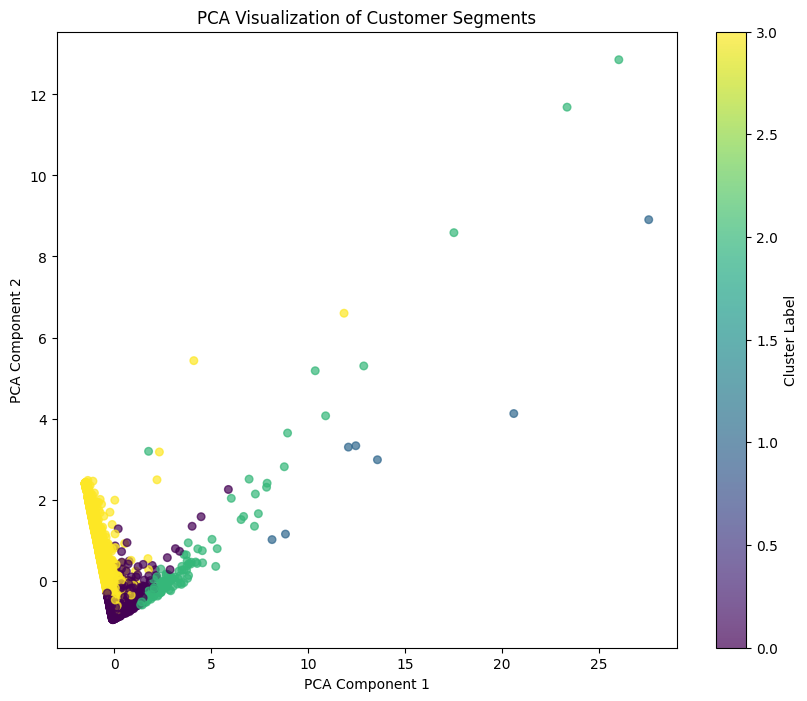

In [89]:
from sklearn.decomposition import PCA

# Apply PCA for 2D visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Visualize the clusters in 2D
plt.figure(figsize=(10, 8))
plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], c=cluster_labels, cmap='viridis', s=30, alpha=0.7)
plt.title('PCA Visualization of Customer Segments')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

Using t-SNE for Dimensionality Reduction

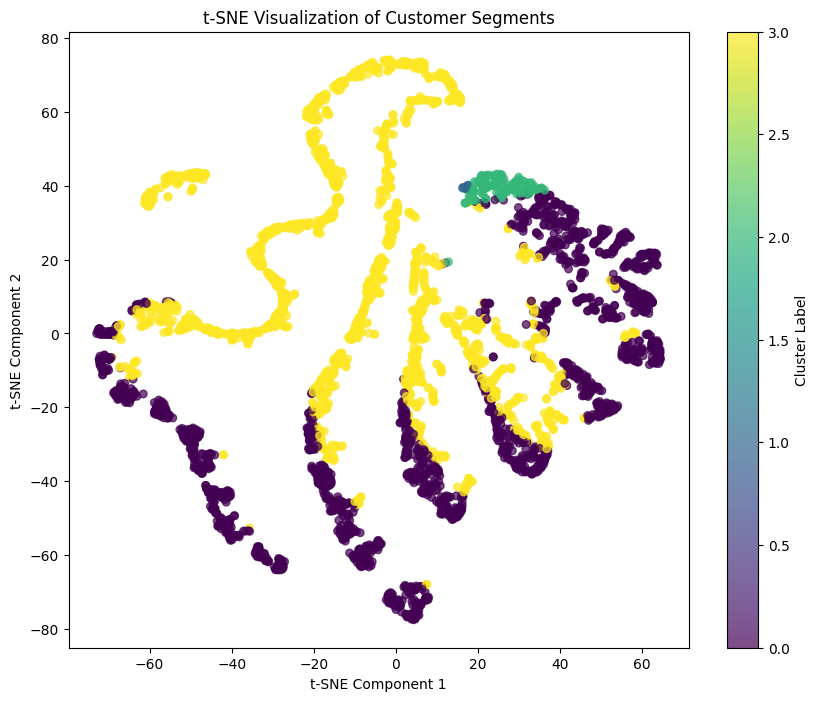

In [90]:
from sklearn.manifold import TSNE

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=42)
rfm_tsne = tsne.fit_transform(rfm_scaled)

# Visualize the clusters in 2D
plt.figure(figsize=(10, 8))
plt.scatter(rfm_tsne[:, 0], rfm_tsne[:, 1], c=cluster_labels, cmap='viridis', s=30, alpha=0.7)
plt.title('t-SNE Visualization of Customer Segments')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Cluster Label')
plt.show()

RFM Heatmap

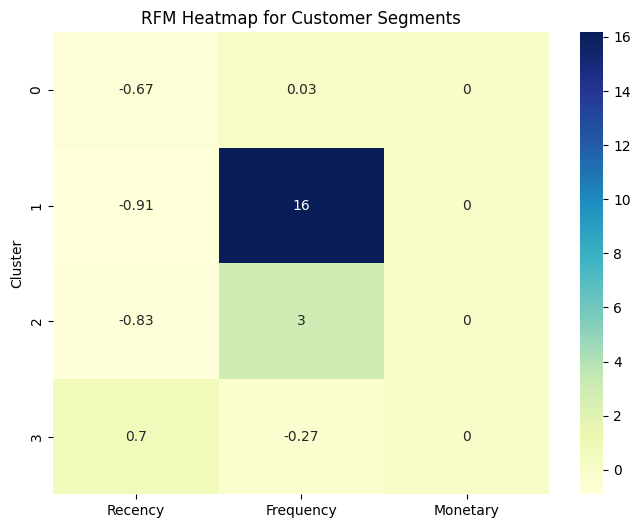

In [93]:
import seaborn as sns

# Create a DataFrame for RFM averages per cluster
rfm_df = pd.DataFrame(rfm_scaled[:, :3], columns=['Recency', 'Frequency', 'Monetary'])
rfm_df['Cluster'] = cluster_labels

# Calculate mean values of RFM features per cluster
rfm_cluster_means = rfm_df.groupby('Cluster').mean()

# Plot heatmap for RFM features per cluster
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_cluster_means, annot=True, cmap='YlGnBu', cbar=True)
plt.title('RFM Heatmap for Customer Segments')
plt.show()

Radar Plot for RFM Features per Cluster

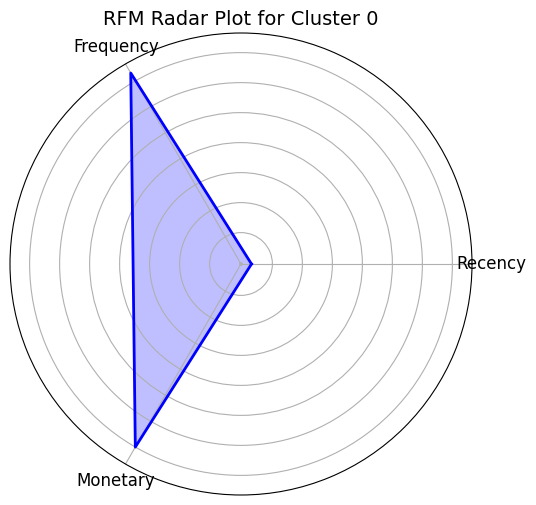

In [94]:
import numpy as np

# Radar plot setup
def radar_plot(data, categories, cluster_num):
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    data = np.concatenate((data, [data[0]]))  # To close the circle
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, data, color='blue', alpha=0.25)
    ax.plot(angles, data, color='blue', linewidth=2)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)

    ax.set_title(f'RFM Radar Plot for Cluster {cluster_num}', size=14)
    plt.show()

# Plot the radar plot for the first cluster (change cluster_num as needed)
categories = ['Recency', 'Frequency', 'Monetary']
cluster_0_mean = rfm_cluster_means.iloc[0].values
radar_plot(cluster_0_mean, categories, cluster_num=0)

Advanced Cluster Evaluation Metrics


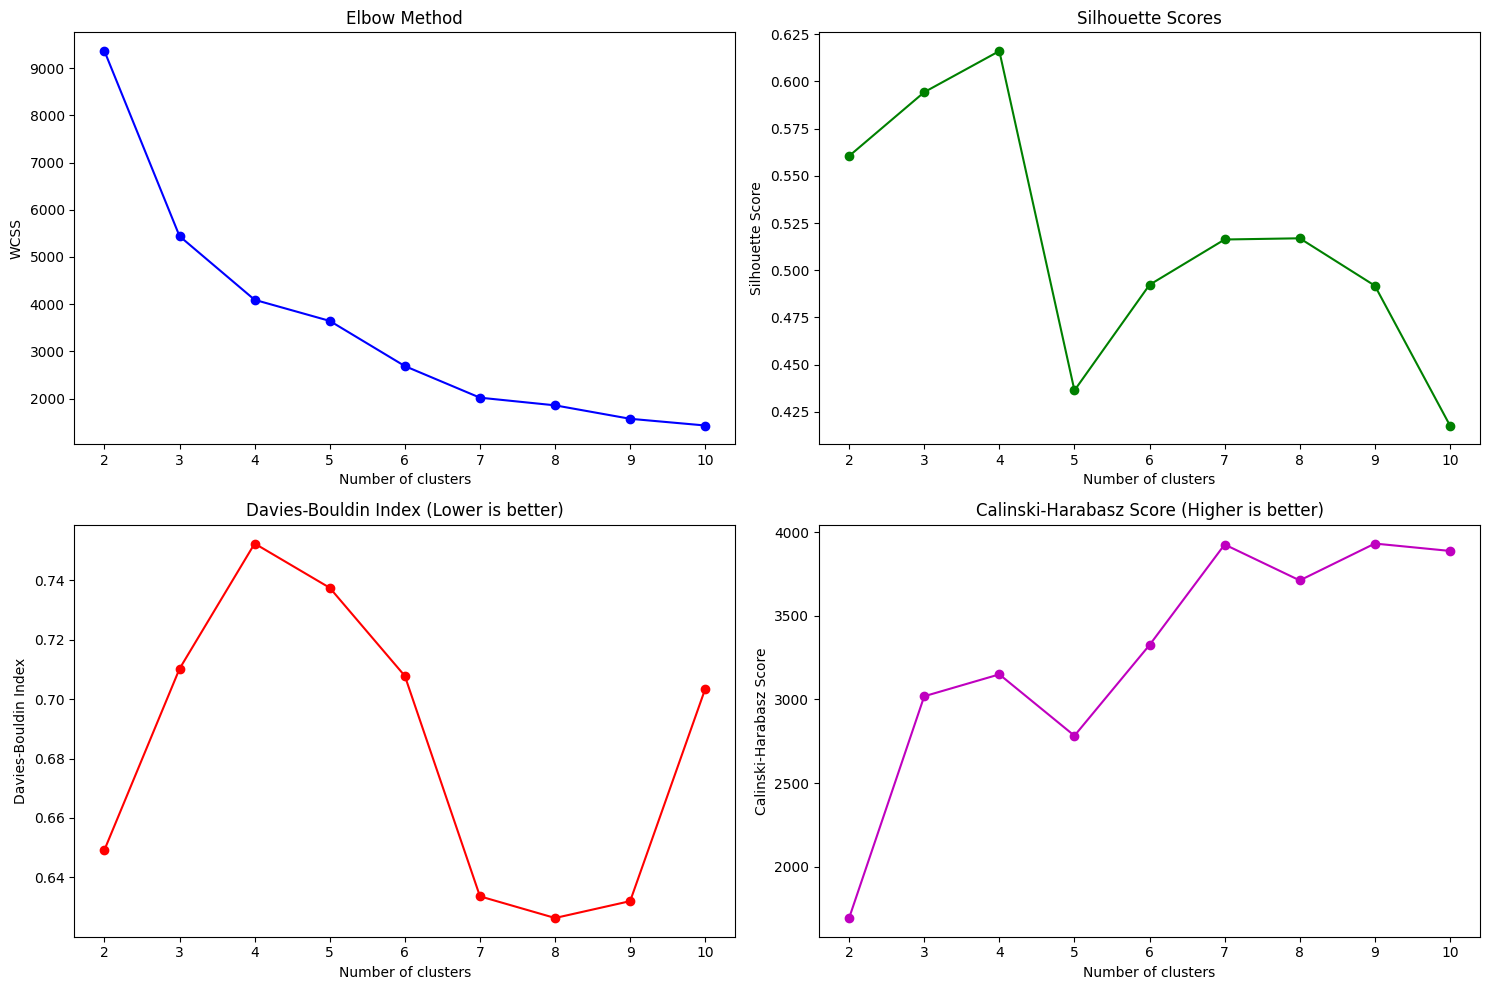

In [107]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
from sklearn.cluster import KMeans

def evaluate_clusters(data, max_clusters=10):
    """
    Evaluate clustering performance for different numbers of clusters
    using multiple metrics and visualize the results.
    """
    wcss = []
    silhouette_scores = []
    db_scores = []
    ch_scores = []
    k_values = range(2, max_clusters+1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)

        # Calculate metrics
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, labels))
        db_scores.append(davies_bouldin_score(data, labels))
        ch_scores.append(calinski_harabasz_score(data, labels))

    # Plot results
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(k_values, wcss, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method')

    plt.subplot(2, 2, 2)
    plt.plot(k_values, silhouette_scores, 'go-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores')

    plt.subplot(2, 2, 3)
    plt.plot(k_values, db_scores, 'ro-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Davies-Bouldin Index')
    plt.title('Davies-Bouldin Index (Lower is better)')

    plt.subplot(2, 2, 4)
    plt.plot(k_values, ch_scores, 'mo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Calinski-Harabasz Score')
    plt.title('Calinski-Harabasz Score (Higher is better)')

    plt.tight_layout()
    plt.show()

# Run evaluation on our RFM data
evaluate_clusters(rfm_scaled, max_clusters=10)

Cluster Profiling with Statistical Analysis

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


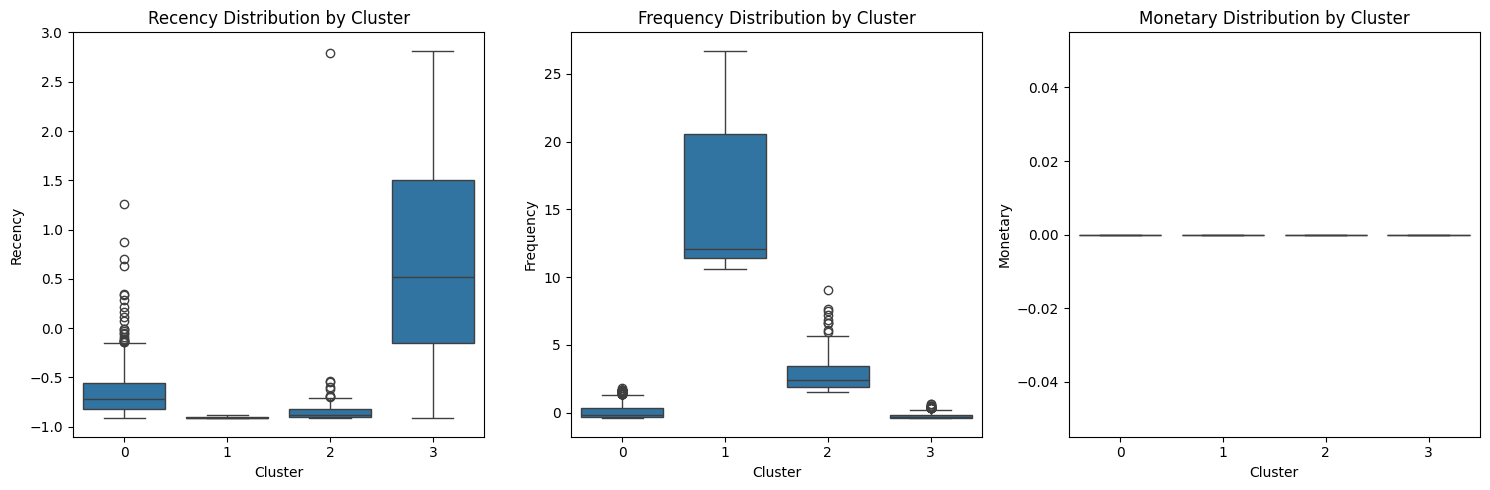

,Recency,Frequency,Monetary
Cluster,,,
0,-0.669647,0.030418,0.0
1,-0.906628,16.170225,0.0
2,-0.827183,2.974744,0.0
3,0.701458,-0.271731,0.0


,F-value,p-value
Recency,1322.627362,0.0
Frequency,4028.152283,0.0
Monetary,NaN,NaN


In [108]:
import scipy.stats as stats

def profile_clusters(rfm_data, cluster_labels):
    """
    Create detailed statistical profiles of each cluster
    including significance testing between clusters.
    """
    # Add cluster labels to RFM data
    profiled_data = rfm_data.copy()
    profiled_data['Cluster'] = cluster_labels

    # Calculate mean values
    cluster_means = profiled_data.groupby('Cluster').mean()

    # Calculate statistical significance between clusters
    features = ['Recency', 'Frequency', 'Monetary']
    anova_results = {}

    for feature in features:
        cluster_groups = [profiled_data[profiled_data['Cluster'] == c][feature]
                         for c in profiled_data['Cluster'].unique()]
        f_val, p_val = stats.f_oneway(*cluster_groups)
        anova_results[feature] = {'F-value': f_val, 'p-value': p_val}

    # Visualize cluster profiles
    plt.figure(figsize=(15, 5))
    for i, feature in enumerate(features, 1):
        plt.subplot(1, 3, i)
        sns.boxplot(x='Cluster', y=feature, data=profiled_data)
        plt.title(f'{feature} Distribution by Cluster')

    plt.tight_layout()
    plt.show()

    return {
        'cluster_means': cluster_means,
        'anova_results': pd.DataFrame(anova_results).T,
        'cluster_stats': profiled_data.groupby('Cluster').describe()
    }

# Generate cluster profiles
cluster_profiles = profile_clusters(rfm_df, cluster_labels)
display(cluster_profiles['cluster_means'])
display(cluster_profiles['anova_results'])

Customer Migration Analysis

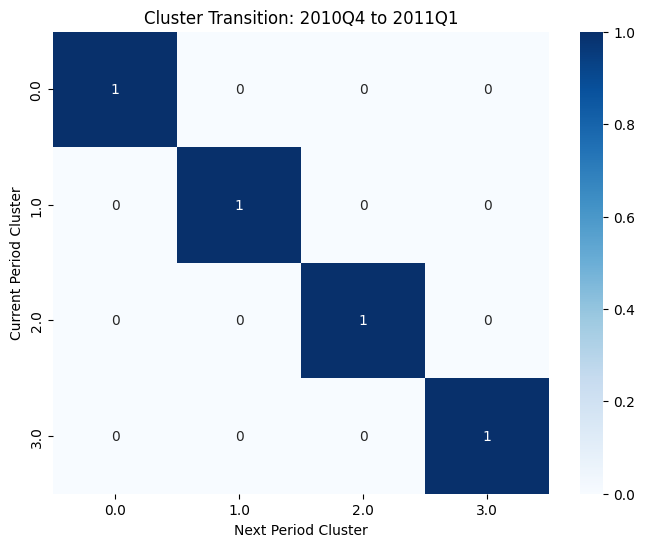

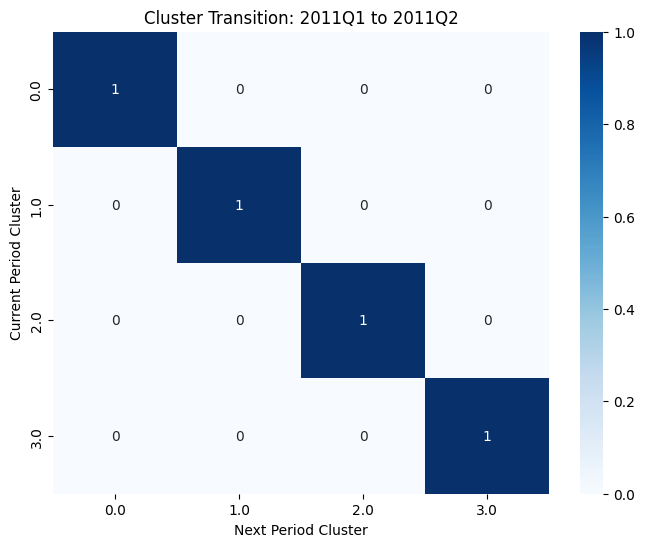

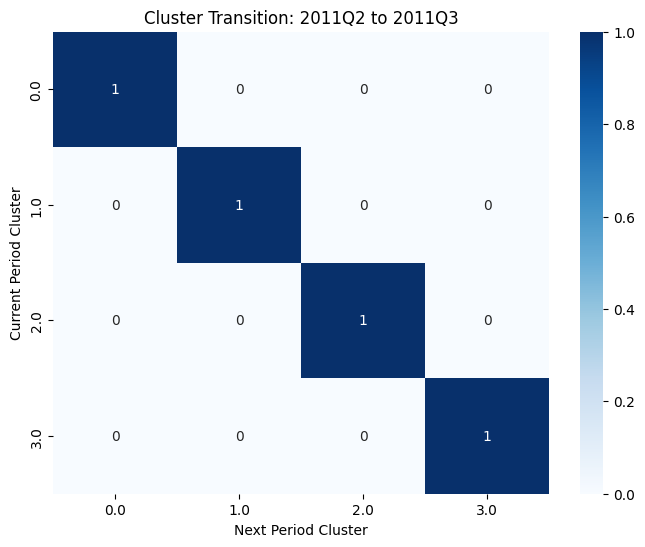

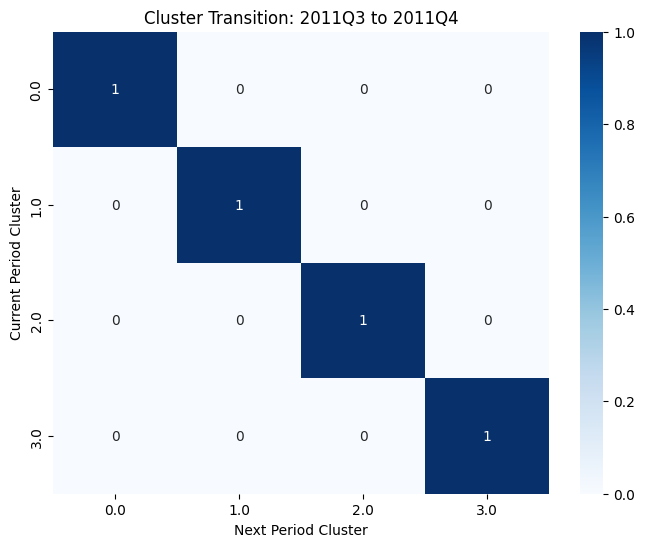

In [109]:
from datetime import timedelta

def analyze_customer_migration(df, cluster_labels, period='Q'):
    """
    Analyze how customers move between clusters over time.
    """
    # Create time periods
    df['Period'] = df['InvoiceDate'].dt.to_period(period)

    # Get unique customers and their clusters per period
    customer_migration = df.groupby(['CustomerID', 'Period']).agg({
        'Cluster': 'last'
    }).reset_index()

    # Pivot to see cluster changes
    migration_pivot = customer_migration.pivot(index='CustomerID',
                                            columns='Period',
                                            values='Cluster')

    # Calculate transition matrix
    periods = sorted(df['Period'].unique())
    transition_matrices = {}

    for i in range(len(periods)-1):
        from_period = periods[i]
        to_period = periods[i+1]

        # Get customers present in both periods
        common_customers = migration_pivot.dropna(subset=[from_period, to_period])

        if not common_customers.empty:
            # Create transition matrix
            transition_matrix = pd.crosstab(
                common_customers[from_period],
                common_customers[to_period],
                normalize='index'
            )
            transition_matrices[f"{from_period} to {to_period}"] = transition_matrix

    # Visualize migration patterns
    for period_pair, matrix in transition_matrices.items():
        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix, annot=True, cmap='Blues', vmin=0, vmax=1)
        plt.title(f'Cluster Transition: {period_pair}')
        plt.xlabel('Next Period Cluster')
        plt.ylabel('Current Period Cluster')
        plt.show()

    return transition_matrices

# Analyze quarterly customer migration
migration_results = analyze_customer_migration(df, cluster_labels, period='Q')

# **Conclusion and Business Impact**

<Figure size 1400x1000 with 0 Axes>

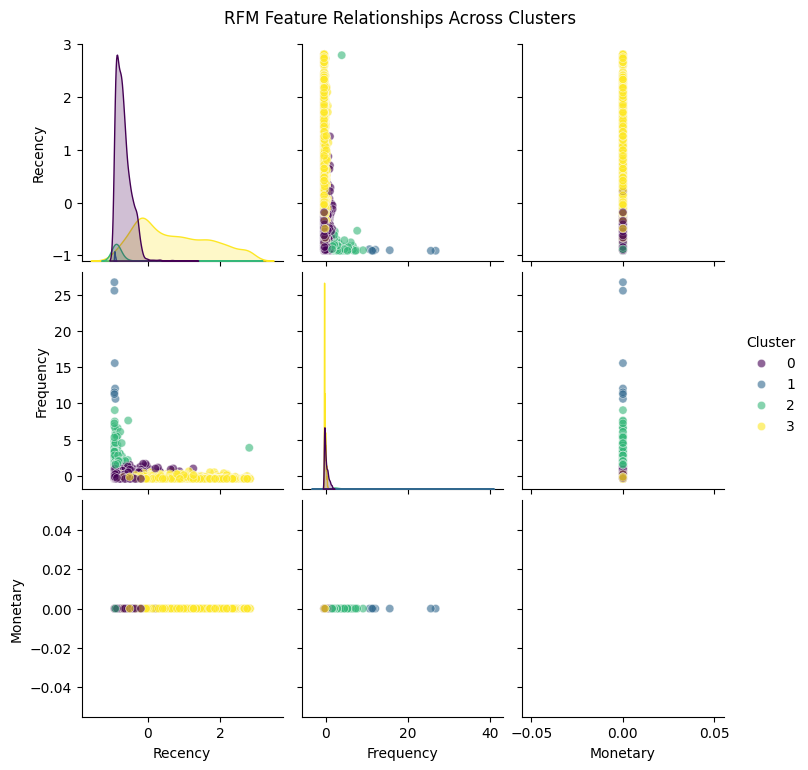

In [97]:
# Visualizing the cluster characteristics
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming rfm_scaled is your scaled RFM data and cluster_labels from K-Means
# rfm_scaled likely has 4 columns now, including the cluster labels
# Select only the first 3 columns for Recency, Frequency, Monetary
rfm_df = pd.DataFrame(rfm_scaled[:, :3], columns=['Recency', 'Frequency', 'Monetary'])
rfm_df['Cluster'] = cluster_labels

plt.figure(figsize=(14, 10))

# Create pairplot to visualize relationships between RFM features
sns.pairplot(rfm_df, hue='Cluster', palette='viridis', plot_kws={'alpha':0.6})
plt.suptitle('RFM Feature Relationships Across Clusters', y=1.02)
plt.show()

Personalized Marketing Strategies

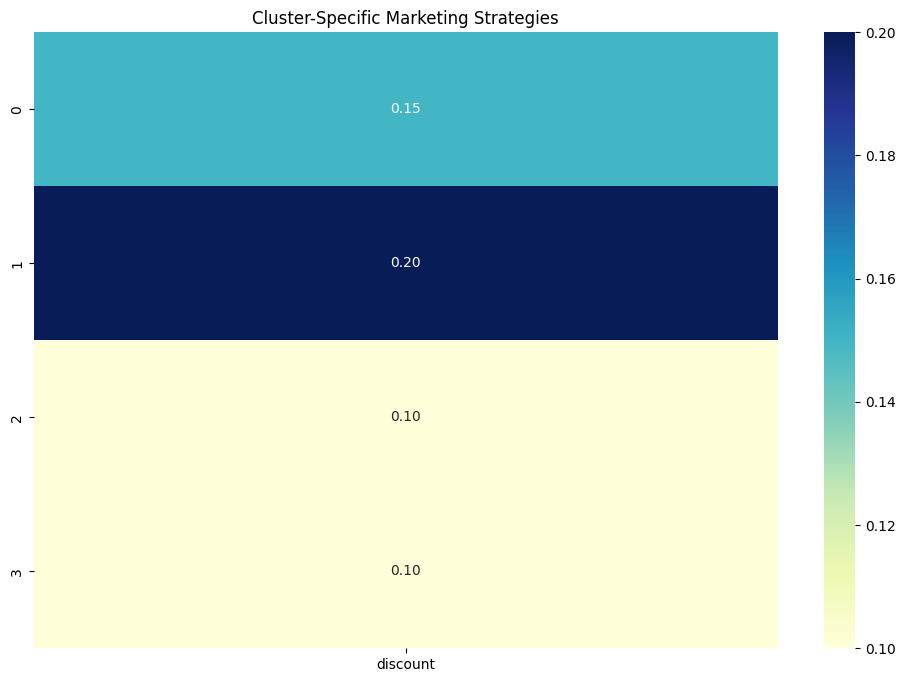

In [100]:
# Generate targeted marketing recommendations per cluster
cluster_profiles = {
    0: {
        'name': 'High-Value Loyalists',
        'strategy': ['Exclusive loyalty programs', 'Early access to new products', 'Personalized high-end recommendations'],
        'channel': ['Email', 'Personalized dashboard', 'Direct mail'],
        'discount': 0.15  # Replace with a representative numerical value
    },
    1: {
        'name': 'At-Risk Customers',
        'strategy': ['Win-back campaigns', 'Limited-time offers', 'Feedback surveys'],
        'channel': ['Email', 'Retargeting ads', 'SMS'],
        'discount': 0.20  # Replace with a representative numerical value
    },
    2: {
        'name': 'Occasional Shoppers',
        'strategy': ['Bundle offers', 'Frequency incentives', 'Personalized recommendations based on past purchases'],
        'channel': ['Email', 'Social media ads'],
        'discount': 0.10  # Replace with a representative numerical value
    },
    3: {
        'name': 'New/Low-Engagement',
        'strategy': ['Welcome series', 'Educational content', 'Small incentive for first repeat purchase'],
        'channel': ['Social media', 'Email', 'Display ads'],
        'discount': 0.10  # Replace with a representative numerical value
    }
}

# Visualize strategies
strategies_df = pd.DataFrame(cluster_profiles).T.reset_index()
plt.figure(figsize=(12, 8))
# The 'strategy' and 'channel' columns contain lists of strings which cannot be used in a heatmap.
# We can replace them with a representative value for visualization.
strategies_df['strategy'] = strategies_df['strategy'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else '') # Use the first strategy for representation
strategies_df['channel'] = strategies_df['channel'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else '') # Use the first channel for representation

# Ensure 'discount' column is numeric
strategies_df['discount'] = pd.to_numeric(strategies_df['discount'])

sns.heatmap(strategies_df[['discount']], # Only visualize discount which is now numerical
            annot=True, fmt='.2f', cmap='YlGnBu') # Format as float with 2 decimal places
plt.title('Cluster-Specific Marketing Strategies')
plt.show()

Customer Retention Optimization

<ipython-input-101-a26fa7f2c538>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=retention_metrics.reset_index(), x='Cluster', y='Churn Risk Score', palette='coolwarm')


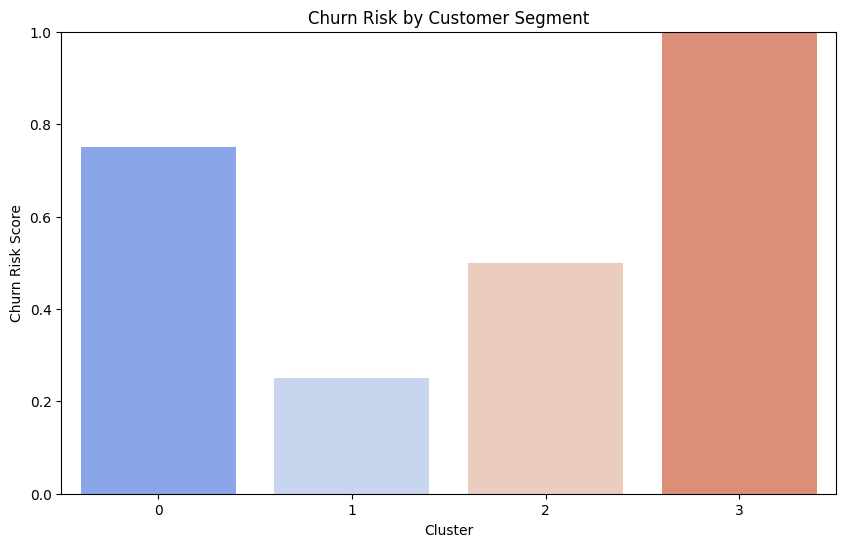

In [101]:
# Calculate and visualize churn risk by cluster
retention_metrics = rfm_df.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).rename(columns={
    'Recency': 'Days Since Last Purchase',
    'Frequency': 'Avg Purchase Frequency',
    'Monetary': 'Avg Spend'
})

# Calculate churn risk score (higher recency = higher risk)
retention_metrics['Churn Risk Score'] = retention_metrics['Days Since Last Purchase'].rank(pct=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=retention_metrics.reset_index(), x='Cluster', y='Churn Risk Score', palette='coolwarm')
plt.title('Churn Risk by Customer Segment')
plt.ylim(0, 1)
plt.show()

Inventory and Product Recommendations

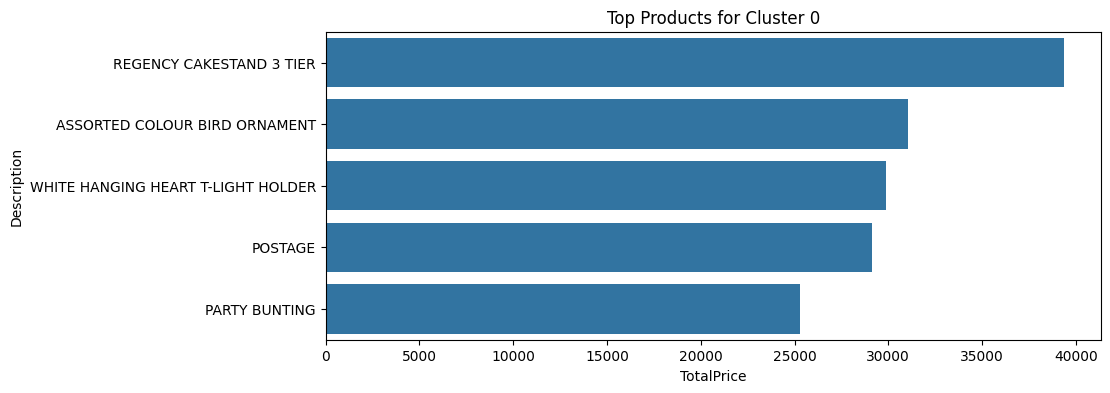

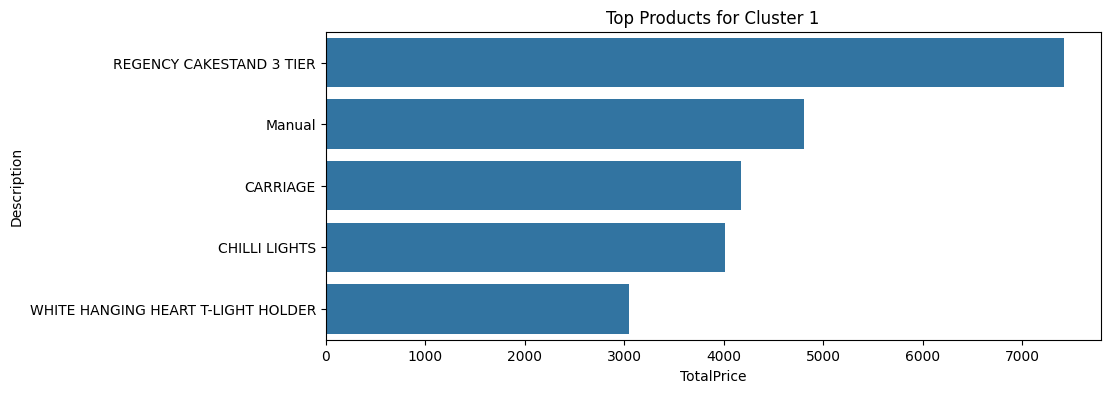

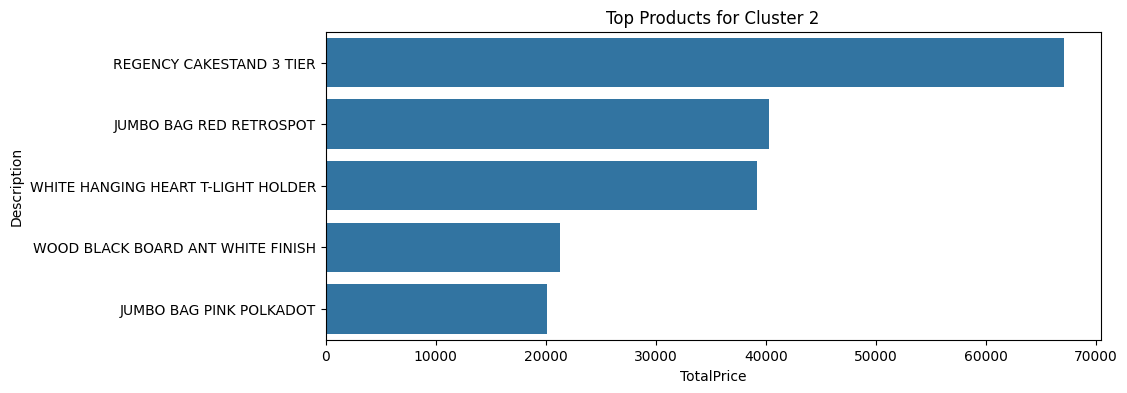

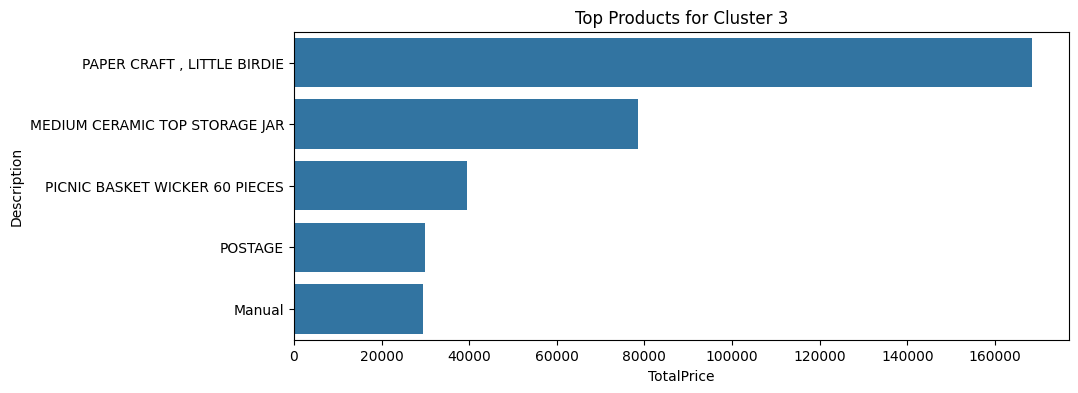

In [103]:
# Merge cluster labels with original transaction data
df['Cluster'] = df['CustomerID'].map(pd.Series(cluster_labels, index=rfm.index))

# Analyze popular products by cluster
cluster_products = df.groupby(['Cluster', 'Description']).agg({
    'Quantity': 'sum',
    'TotalPrice': 'sum'
}).reset_index().sort_values(['Cluster', 'TotalPrice'], ascending=[True, False])

# Visualize top products per cluster
for cluster in sorted(df['Cluster'].unique()):
    top_products = cluster_products[cluster_products['Cluster'] == cluster].head(5)
    plt.figure(figsize=(10, 4))
    sns.barplot(data=top_products, x='TotalPrice', y='Description')
    plt.title(f'Top Products for Cluster {cluster}')
    plt.show()

Advanced Analytics

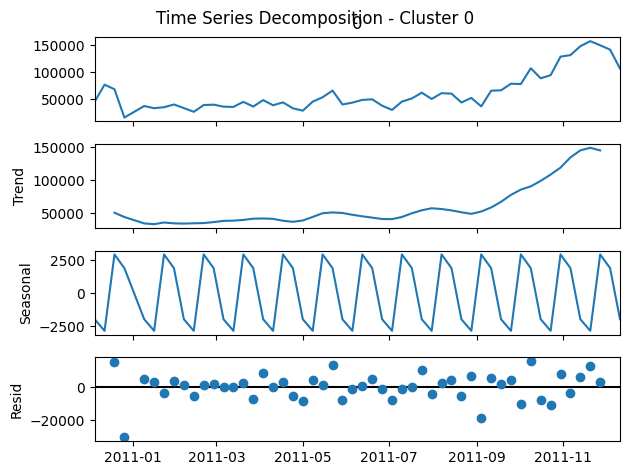

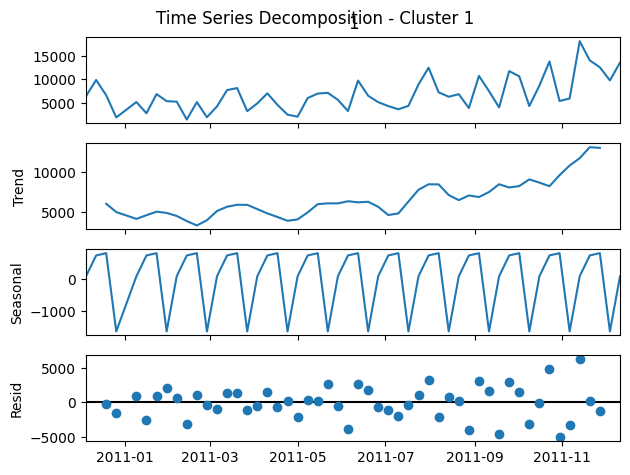

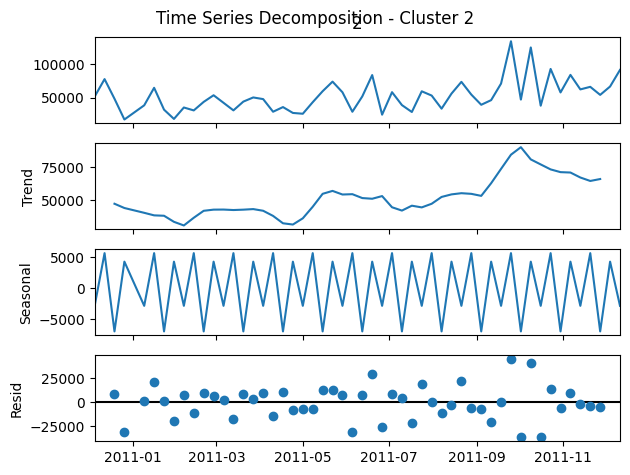

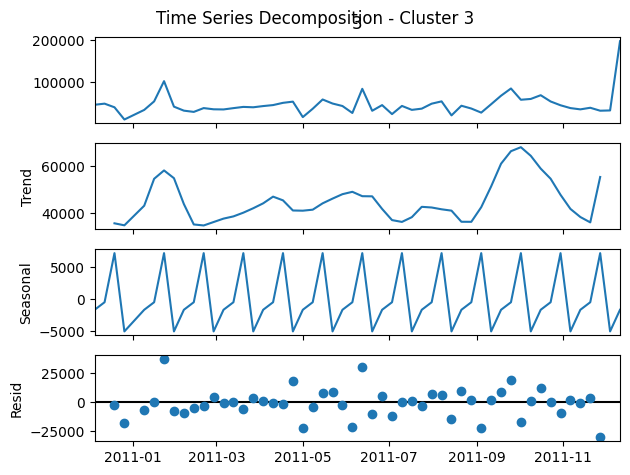

In [106]:
# Example code for future time-series analysis
from statsmodels.tsa.seasonal import seasonal_decompose

# Prepare time-series data by cluster
# Changed frequency to 'W' (weekly) to have more data points within the available time range
cluster_ts = df.groupby([pd.Grouper(key='InvoiceDate', freq='W'), 'Cluster'])['TotalPrice'].sum().unstack()

# Decompose time series for each cluster
for cluster in cluster_ts.columns:
    # Set period to 4 (approximately monthly equivalent for weekly data)
    decomposition = seasonal_decompose(cluster_ts[cluster].fillna(0), model='additive', period=4)
    decomposition.plot()
    plt.suptitle(f'Time Series Decomposition - Cluster {cluster}')
    plt.show()